# Box Office Mojo: Analysis

In [1]:
import pickle

with open('movie_data.pickle','rb') as g:
    df = pickle.load(g)

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   title         1000 non-null   object 
 1   intnl_pct     950 non-null    float64
 2   year          1000 non-null   float64
 3   distributor   1000 non-null   object 
 4   budget        792 non-null    float64
 5   release_date  1000 non-null   object 
 6   rating        877 non-null    object 
 7   run_time      1000 non-null   int64  
 8   genres        1000 non-null   object 
 9   directors     1000 non-null   object 
 10  actors        1000 non-null   object 
dtypes: float64(3), int64(1), object(7)
memory usage: 86.1+ KB


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import cpi

## A // CLEAN & FEATURE ENGINEERING DATA

### A1 // Clean Data

In [4]:
#TARGET // drop null data
#df['intnl_pct'] = df['intnl_pct'].fillna(0) #test-- fill nulls with 0; result: produced high skew
df = df.dropna(subset = ['intnl_pct']).reset_index(drop = True) #test-- drops null value rows

(array([ 12.,  10.,  33.,  63.,  87., 157., 217., 185., 148.,  38.]),
 array([0.002 , 0.0835, 0.165 , 0.2465, 0.328 , 0.4095, 0.491 , 0.5725,
        0.654 , 0.7355, 0.817 ]),
 <BarContainer object of 10 artists>)

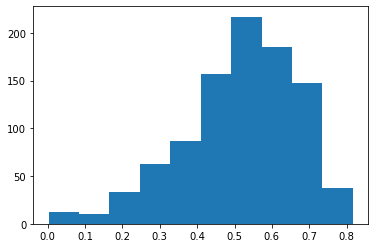

In [5]:
plt.hist(df['intnl_pct'])

In [6]:
#test log(target) to fix heterokedasticity // RESULT: made much worse
#df['intnl_pct_log'] = np.log(df['intnl_pct'])

In [7]:
#test sqroot(target) to fix heteroskedasticity // RESULT: made a bit worse
#df['intnl_pct_sqrt'] = np.sqrt(df['intnl_pct'])

In [8]:
#FEATURES //
#year convert to dt to adjust budget for inflation
df['dt'] = df['year'].astype(int).astype(str)

(array([ 12.,  10.,  33.,  63.,  87., 157., 217., 185., 148.,  38.]),
 array([0.002 , 0.0835, 0.165 , 0.2465, 0.328 , 0.4095, 0.491 , 0.5725,
        0.654 , 0.7355, 0.817 ]),
 <BarContainer object of 10 artists>)

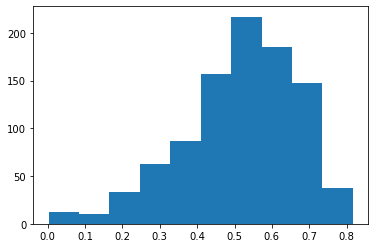

In [9]:
plt.hist(df['intnl_pct'])

In [10]:
df['dt'] = pd.to_datetime(df.dt)

In [11]:
#adjust budget to today's $
def cpi_adjust(x):
    return cpi.inflate(x['budget'],x['dt'])

df['budget_adj'] = df.apply(cpi_adjust, axis = 1)

In [12]:
#convert year back to int
df['year'] = df.year.astype(int)

In [13]:
val = df['distributor'].unique()[17]
df[df['distributor'] == val]

,title,intnl_pct,year,distributor,budget,release_date,rating,run_time,genres,directors,actors,dt,budget_adj
285,Get Out,0.311,2017,"[$4,500,000]",NaN,"February 18, 2016",R,104,"[Horror, Mystery, Thriller]",[Jordan Peele],"[Daniel Kaluuya, Allison Williams, Bradley Whi...",2017-01-01,NaN


In [14]:
#update mis-coded distributor
df.at[285,'distributor'] = 'Other' #for df target nulls dropped
#df.at[287,'distributor'] = 'Other' #for df target nulls = 0

In [15]:
#update mis-coded run time
df['run_time'] = np.where(df['run_time']>500,df['run_time']/60,df['run_time'])

In [16]:
df[df['run_time']>500]

,title,intnl_pct,year,distributor,budget,release_date,rating,run_time,genres,directors,actors,dt,budget_adj


In [17]:
#convert release_date to month only
df.release_date = df.release_date.str.split(" ")

In [18]:
df['release_month'] = df.release_date.apply(lambda x: x[0])

In [19]:
df = df.drop('release_date',axis = 1)

In [20]:
#ID + combine category dupes -- DreamWorks + DreamWorks Distribution
df['distributor'].value_counts().sort_index()

20th Century Studios                     1
Artisan Entertainment                    1
Columbia Pictures                        8
Dimension Films                          7
DreamWorks                              21
DreamWorks Distribution                 17
FilmDistrict                             2
Focus Features                           2
Fox Searchlight Pictures                 4
IFC Films                                1
IMAX                                     1
Lionsgate                               18
MacGillivray Freeman Films               1
Metro-Goldwyn-Mayer (MGM)               14
Miramax                                  9
New Line Cinema                         20
Newmarket Films                          1
Orion Pictures                           2
Other                                    1
Paramount Pictures                     104
RKO Radio Pictures                       1
Relativity Media                         1
Revolution Studios                       8
Roadside At

In [21]:
df['distributor'] = df['distributor'].replace('DreamWorks Distribution','DreamWorks')

### A2 // Create Dummy Vars
- Genres
- Distributor
- Month
- Directors
- Actors
- Rating

*support from https://stackoverflow.com/questions/29034928/pandas-convert-a-column-of-list-to-dummies*

In [22]:
#GENRES

#Create genre dummies df
genre_dummy = pd.get_dummies(df['genres'].explode()).groupby(level=0).sum()

In [23]:
genre_dummy.sum()

Action         411
Adventure      455
Animation      147
Biography       39
Comedy         417
Crime          138
Documentary      4
Drama          302
Family         238
Fantasy        238
History         21
Horror          50
Music           32
Musical         61
Mystery         91
Romance        152
Sci-Fi         230
Short            1
Sport           28
Thriller       236
War             27
Western         14
dtype: int64

In [24]:
#ID genres < 25
genre_col_list = ['Documentary', 'History', 'Short', 'Western']

In [25]:
#drop col_list
genre_dummy = genre_dummy.drop(genre_col_list, axis = 1)

In [26]:
#DISTRIBUTOR

#replace dist w counts < 10 as 'Other'
s_dis = df['distributor'].value_counts()
other_dist = list(s_dis[s_dis < 10].index)
df['distributor'] = df['distributor'].replace(other_dist,'Other')

In [27]:
#get distribution dummy df
dist_dummy = pd.get_dummies(df['distributor'], drop_first = True)

In [28]:
dist_dummy.sum()

Lionsgate                               18
Metro-Goldwyn-Mayer (MGM)               14
New Line Cinema                         20
Other                                   74
Paramount Pictures                     104
Sony Pictures Entertainment (SPE)       99
TriStar Pictures                        12
Twentieth Century Fox                  119
Universal Pictures                     126
Walt Disney Studios Motion Pictures    164
Warner Bros.                           162
dtype: int64

In [29]:
#MONTH

#get month dummy df
month_dummy = pd.get_dummies(df['release_month'],drop_first = True)

In [30]:
month_dummy.sum()

August        58
December     138
February      50
January       22
July         113
June         145
March         71
May          108
November     109
October       54
September     44
dtype: int64

In [31]:
#DIRECTORS

#get directors dummy df
direct_dummy = pd.get_dummies(df['directors'].explode()).groupby(level=0).sum()

In [32]:
#drop directors < 8
s_dir = direct_dummy.sum()
other_dir = list(s_dir[s_dir < 8].index)

In [33]:
#drop col_list
direct_dummy = direct_dummy.drop(other_dir, axis = 1)

In [34]:
#ACTORS

#get actors dummy df
actor_dummy = pd.get_dummies(df['actors'].explode()).groupby(level=0).sum()

In [35]:
#drop actors < 10
s_act = actor_dummy.sum()
other_act = list(s_act[s_act < 10].index)

In [36]:
#drop col_list
actor_dummy = actor_dummy.drop(other_act, axis = 1)

### A3 // Address Null Values
- impute data for rows w feat null values (budget, rating)

(array([104., 167., 174., 113., 107.,  68.,  27.,  18.,   4.,   3.]),
 array([2.16605407e+04, 4.33405758e+07, 8.66594911e+07, 1.29978406e+08,
        1.73297322e+08, 2.16616237e+08, 2.59935152e+08, 3.03254068e+08,
        3.46572983e+08, 3.89891898e+08, 4.33210813e+08]),
 <BarContainer object of 10 artists>)

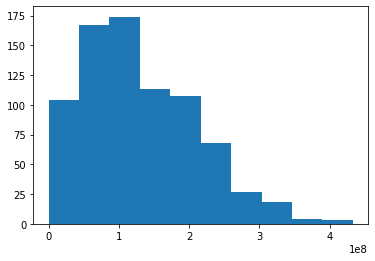

In [37]:
#FEATURE // ID skewness in budget data
plt.hist(df['budget_adj'])

In [38]:
#budget is skewed, so impute median value
df['budget_adj'].fillna(df['budget_adj'].median(), inplace = True)

In [39]:
#FEATURE // Review rating data
df['rating'].value_counts()

PG-13    416
R        215
PG       209
G         24
Name: rating, dtype: int64

In [40]:
#Impute 'missing' rating for null values
df['rating'].fillna('missing', inplace = True)

In [41]:
df['rating'].value_counts()

PG-13      416
R          215
PG         209
missing     86
G           24
Name: rating, dtype: int64

In [42]:
#get rating dummy df
rating_dummy = pd.get_dummies(df['rating'],drop_first = True)

In [43]:
rating_dummy.sum()

PG         209
PG-13      416
R          215
missing     86
dtype: int64

In [44]:
df.head(1)

,title,intnl_pct,year,distributor,budget,rating,run_time,genres,directors,actors,dt,budget_adj,release_month
0,Star Wars: Episode VII - The Force Awakens,0.547,2015,Walt Disney Studios Motion Pictures,245000000.0,PG-13,138.0,"[Action, Adventure, Sci-Fi]",[J.J. Abrams],"[Daisy Ridley, John Boyega, Oscar Isaac, Domhn...",2015-01-01,3.064201e+08,December


## B // REVIEW OLS

- Target appears to have some cone shaped heteroskedasticity. Attempted to fix via log and sqrt transformations without success.
- The ratings feature vars had high VIF scores and p-values. After some adjustment of the data without improvement, I dropped these columns, and the metrics for collinearity improved. 
- OLS overview: R2 = .484; Adj R2 = .427; Durbin-Watson = 2.023
    - dropped and re-added other feature vars but this only seemed to reduce the R2 metrics.

In [45]:
#create target df w none, log, and sqrt transformations to address heteroskedasticity

y = df.loc[:,'intnl_pct'].astype(float) #regular test
#y = df.loc[:,'intnl_pct_log'].astype(float) #log test // results poor
#y = df.loc[:,'intnl_pct_sqrt'].astype(float) #sqrt test // results poor

In [46]:
y.describe()

count    950.000000
mean       0.516157
std        0.152769
min        0.002000
25%        0.428250
50%        0.530500
75%        0.625000
max        0.817000
Name: intnl_pct, dtype: float64

In [47]:
#create features df

df_feat = df.drop(columns = ['dt','budget','rating','genres','directors','actors','release_month','distributor'])


In [48]:
df_feat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 950 entries, 0 to 949
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   title       950 non-null    object 
 1   intnl_pct   950 non-null    float64
 2   year        950 non-null    int64  
 3   run_time    950 non-null    float64
 4   budget_adj  950 non-null    float64
dtypes: float64(3), int64(1), object(1)
memory usage: 37.2+ KB


In [49]:
#Removed rating feat due to high VIF
#df_feat = pd.merge(df_feat,rating_dummy,left_index = True, right_index = True)

In [50]:
df_feat = pd.merge(df_feat,actor_dummy,left_index = True, right_index = True)

In [51]:
df_feat = pd.merge(df_feat,genre_dummy,left_index = True, right_index = True)

In [52]:
df_feat = pd.merge(df_feat,direct_dummy,left_index = True, right_index = True)

In [53]:
df_feat = pd.merge(df_feat,month_dummy,left_index = True, right_index = True)

In [54]:
df_feat = pd.merge(df_feat,dist_dummy,left_index = True, right_index = True)

In [55]:
df_feat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 950 entries, 0 to 949
Data columns (total 97 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   title                                950 non-null    object 
 1   intnl_pct                            950 non-null    float64
 2   year                                 950 non-null    int64  
 3   run_time                             950 non-null    float64
 4   budget_adj                           950 non-null    float64
 5   Adam Sandler                         950 non-null    uint8  
 6   Angelina Jolie                       950 non-null    uint8  
 7   Anne Hathaway                        950 non-null    uint8  
 8   Antonio Banderas                     950 non-null    uint8  
 9   Ben Affleck                          950 non-null    uint8  
 10  Ben Stiller                          950 non-null    uint8  
 11  Brad Pitt                       

In [56]:
import statsmodels.api as sm

In [57]:
df_x = df_feat.drop(columns = ['title','intnl_pct'])

In [58]:
X = sm.add_constant(df_x)

/Users/oliviaoffutt/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [59]:
model = sm.OLS(y,X,data = df_feat)
results = model.fit()

In [60]:
#normal target: R2= .484, Adj R2 = .427
#log target: R2= .345, Adj R2 = .272
#sqrt target: R2 = .461, Adj R2 = .401

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              intnl_pct   R-squared:                       0.484
Model:                            OLS   Adj. R-squared:                  0.427
Method:                 Least Squares   F-statistic:                     8.448
Date:                Tue, 12 Jul 2022   Prob (F-statistic):           2.36e-73
Time:                        22:46:56   Log-Likelihood:                 752.11
No. Observations:                 950   AIC:                            -1312.
Df Residuals:                     854   BIC:                            -846.0
Df Model:                          95                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
const                                  -7.6140      0.812     -9.371      0.000      -9.209      -6.019
year                                    0.0040      0.000      9.749      0.000       0.003       0.005
run_time                                0.0007      0.000      2.693      0.007       0.000       0.001
budget_adj                           4.041e-10   7.62e-11      5.302      0.000    2.55e-10    5.54e-10
Adam Sandler                           -0.0373      0.031     -1.187      0.235      -0.099       0.024
Angelina Jolie                          0.0464      0.034      1.350      0.177      -0.021       0.114
Anne Hathaway                           0.0448      0.035      1.263      0.207      -0.025       0.114
Antonio Banderas                       -0.0032      0.039     -0.082      0.934      -0.081       0.074
Ben Affleck                            -0.0648      0.036     -1.787      0.074      -0.136       0.006
Ben Stiller                             0.0556      0.036      1.543      0.123      -0.015       0.126
Brad Pitt                               0.0825      0.035      2.375      0.018       0.014       0.151
Bruce Willis                            0.0505      0.038      1.314      0.189      -0.025       0.126
Cameron Diaz                            0.0550      0.034      1.601      0.110      -0.012       0.123
Cate Blanchett                          0.0236      0.037      0.639      0.523      -0.049       0.096
Chris Evans                            -0.0284      0.040     -0.703      0.482      -0.108       0.051
Chris Pratt                            -0.0413      0.039     -1.050      0.294      -0.118       0.036
Denzel Washington                      -0.0871      0.036     -2.421      0.016      -0.158      -0.016
Dwayne Johnson                          0.0852      0.032      2.678      0.008       0.023       0.148
Eddie Murphy                           -0.0084      0.034     -0.249      0.804      -0.075       0.058
Emma Watson                             0.0506      0.044      1.152      0.250      -0.036       0.137
Harrison Ford                          -0.0587      0.031     -1.899      0.058      -0.119       0.002
Hugh Jackman                           -0.0112      0.036     -0.313      0.754      -0.081       0.059
Ian McKellen                            0.0664      0.042      1.584      0.114      -0.016       0.149
Jim Carrey                              0.0352      0.030      1.169      0.243      -0.024       0.094
John Travolta                           0.0084      0.037      0.226      0.821      -0.064       0.081
Johnny Depp                             0.0378      0.038      0.997      0.319      -0.037       0.112
Julia Roberts                           0.0380      0.031      1.22

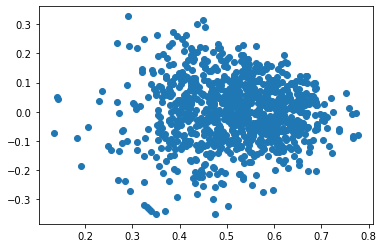

In [61]:
#normal target: observe a cone shape indication hetersoskedasticity
fig_resid = plt.scatter(results.predict(),results.resid)

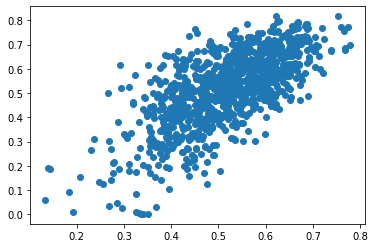

In [62]:
fig_predict = plt.scatter(results.predict(),y)

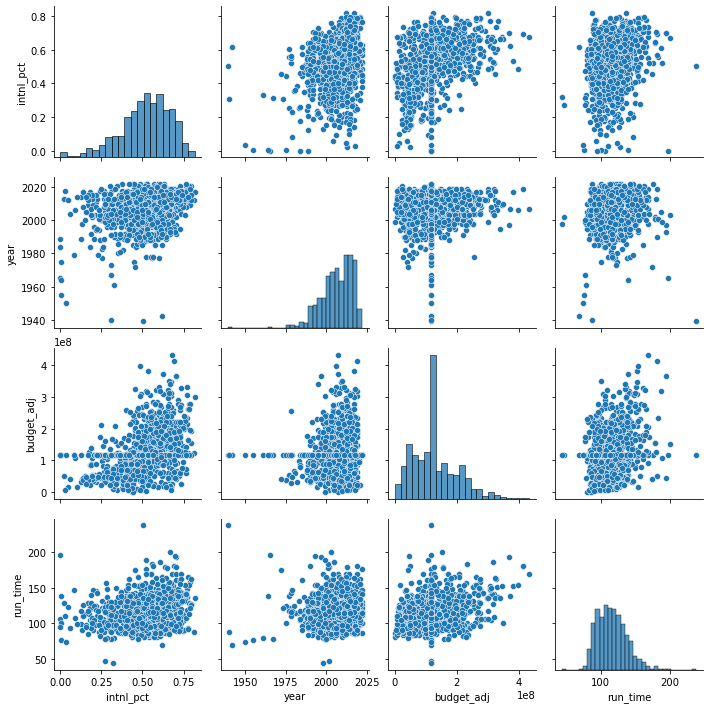

In [63]:
sns.pairplot(df_feat[['intnl_pct','year','budget_adj','run_time']])

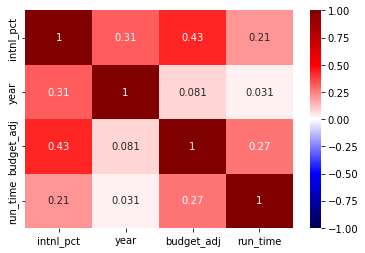

In [64]:
sns.heatmap(df_feat[['intnl_pct','year','budget_adj','run_time']].corr(), cmap="seismic", annot=True, vmin=-1, vmax=1);

In [65]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [66]:
variables = results.model.exog

In [67]:
vif = [variance_inflation_factor(variables, i)
      for i in range(variables.shape[1])]
vif

[46904.51786858061,
 1.3665593787204184,
 2.45963645827455,
 2.2035898233985636,
 1.1614104532605205,
 1.1330463361047305,
 1.114030154452895,
 1.1496843275447528,
 1.1637961537591317,
 1.3382949540798177,
 1.1582011113574955,
 1.2012081907998304,
 1.2194485390507732,
 1.1144965448175082,
 1.3231421582487437,
 1.1442708020227248,
 1.1477753608937684,
 1.263002053460803,
 1.2688177997231387,
 1.4262026329311837,
 1.1948598968698758,
 1.2293495497942541,
 1.301908010582363,
 1.1345606107059025,
 1.114668216129335,
 1.2714251384010438,
 1.141541943926611,
 1.1871389909146794,
 1.1607343846392852,
 1.1128369675990246,
 1.1888551869423705,
 1.1318265475698295,
 1.0837564536193751,
 1.1090297304696781,
 1.247386510164457,
 1.4608065786205624,
 1.1138125163292014,
 1.1007914629553546,
 1.2188971555513795,
 1.0945219878810106,
 1.1687132646410783,
 1.1620744699623033,
 1.231743929770581,
 1.154908664646559,
 1.3151849679200978,
 1.2295040845444718,
 1.166593508614882,
 2.6266410944638947,
 2.5

## C // VALIDATION AND TESTING

**OLS**
- R2 = 0.33 +- 0.11
- MAE = 0.1 +- 0.01

**OLS Polynomial**
- R2 = -0.21 +- 0.36
- MAE = 0.13 +- 0.02

**OLS Ridge**
- R2 = .29
- MAE = 0.09

**OLS Lasso**
- R2 = .33
- MAE = 0.09

### C1 // OLS Cross Validation 

In [68]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import r2_score, mean_absolute_error

**Create train/test 80-20 split**

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=10)

**OLS Cross Validation**

In [70]:
lm = LinearRegression()

kf = KFold(n_splits = 5,
           shuffle = True,
           random_state = 10)

In [72]:
lm_cv_r2 = cross_val_score(lm, X_train, y_train,
                       cv = kf,
                       scoring = 'r2')
print(lm_cv_r2)

[0.3961999  0.44535595 0.3609847  0.13781615 0.29627534]


In [74]:
print(np.round(np.mean(lm_cv_r2),2), '+-', np.round(np.std(lm_cv_r2),2))

0.33 +- 0.11


In [75]:
lm_cv_mae = cross_val_score(lm, X_train, y_train,
                       cv = kf,
                       scoring = 'neg_mean_absolute_error')
print(lm_cv_mae)

[-0.09896985 -0.09998686 -0.09148211 -0.10803821 -0.10391678]


In [76]:
print(np.round(np.mean(lm_cv_mae),2), '+-', np.round(np.std(lm_cv_mae),2))

-0.1 +- 0.01


### C2 // Polynomial Regression Cross Validation

In [77]:
poly = PolynomialFeatures(degree=2) 

In [78]:
X_train_poly = poly.fit_transform(X_train.values)
X_test_poly = poly.transform(X_test.values)

lm_poly = LinearRegression()

In [83]:
lm_cv_poly_r2 = cross_val_score(lm_poly, X_train_poly, y_train,
                       cv = kf,
                       scoring = 'r2')
print(lm_cv_poly_r2)

[ 0.23373534 -0.07053366 -0.12093201 -0.22441971 -0.86589226]


In [84]:
print(np.round(np.mean(lm_cv_poly_r2),2), '+-', np.round(np.std(lm_cv_poly_r2),2))

-0.21 +- 0.36


In [85]:
lm_cv_poly_mae = cross_val_score(lm_poly, X_train_poly, y_train,
                       cv = kf,
                       scoring = 'neg_mean_absolute_error')
print(lm_cv_poly_mae)

[-0.10654087 -0.13236352 -0.11810634 -0.11938324 -0.15375902]


In [86]:
print(np.round(np.mean(lm_cv_poly_mae),2), '+-', np.round(np.std(lm_cv_poly_mae),2))

-0.13 +- 0.02


### C3 // Regularization testing Ridge Regularization CV

In [87]:
#test and train_val sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=10)

In [88]:
y_train.shape # 80%

(760,)

In [89]:
y_test.shape # 20%

(190,)

In [90]:
#standardize features
std = StandardScaler()
std.fit(X_train.values)

StandardScaler()

In [91]:
#standardize X train and test sets
X_tr = std.transform(X_train.values)
X_te = std.transform(X_test.values)

In [92]:
#alpha tuning using cross validtion w training data
alphavec = 10**np.linspace(-2,2,200)
ridge_model = RidgeCV(alphas = alphavec, cv = 5)
ridge_model.fit(X_tr, y_train)

RidgeCV(alphas=array([1.00000000e-02, 1.04737090e-02, 1.09698580e-02, 1.14895100e-02,
       1.20337784e-02, 1.26038293e-02, 1.32008840e-02, 1.38262217e-02,
       1.44811823e-02, 1.51671689e-02, 1.58856513e-02, 1.66381689e-02,
       1.74263339e-02, 1.82518349e-02, 1.91164408e-02, 2.00220037e-02,
       2.09704640e-02, 2.19638537e-02, 2.30043012e-02, 2.40940356e-02,
       2.52353917e-02, 2.64308149e-0...
       3.44896226e+01, 3.61234270e+01, 3.78346262e+01, 3.96268864e+01,
       4.15040476e+01, 4.34701316e+01, 4.55293507e+01, 4.76861170e+01,
       4.99450512e+01, 5.23109931e+01, 5.47890118e+01, 5.73844165e+01,
       6.01027678e+01, 6.29498899e+01, 6.59318827e+01, 6.90551352e+01,
       7.23263390e+01, 7.57525026e+01, 7.93409667e+01, 8.30994195e+01,
       8.70359136e+01, 9.11588830e+01, 9.54771611e+01, 1.00000000e+02]),
        cv=5)

In [93]:
ridge_model.alpha_

100.0

In [94]:
#adjusted standardized coeffecients with selected lambda
adj_coeff_ridge = list(zip(X_train.columns, ridge_model.coef_))

In [95]:
test_pred = ridge_model.predict(X_te)

In [96]:
mean_absolute_error(y_test, test_pred)

0.0920618377860823

In [97]:
r2_score(y_test,test_pred)

0.290804821468989

### C4 // Regularization testing Lasso Regression CV

In [98]:
#Lasso Test
#alpha tuning using cross validtion w training data
alphavec = 10**np.linspace(-2,2,200)
lasso_model = LassoCV(alphas = alphavec, cv = 5)
lasso_model.fit(X_tr, y_train)

LassoCV(alphas=array([1.00000000e-02, 1.04737090e-02, 1.09698580e-02, 1.14895100e-02,
       1.20337784e-02, 1.26038293e-02, 1.32008840e-02, 1.38262217e-02,
       1.44811823e-02, 1.51671689e-02, 1.58856513e-02, 1.66381689e-02,
       1.74263339e-02, 1.82518349e-02, 1.91164408e-02, 2.00220037e-02,
       2.09704640e-02, 2.19638537e-02, 2.30043012e-02, 2.40940356e-02,
       2.52353917e-02, 2.64308149e-0...
       3.44896226e+01, 3.61234270e+01, 3.78346262e+01, 3.96268864e+01,
       4.15040476e+01, 4.34701316e+01, 4.55293507e+01, 4.76861170e+01,
       4.99450512e+01, 5.23109931e+01, 5.47890118e+01, 5.73844165e+01,
       6.01027678e+01, 6.29498899e+01, 6.59318827e+01, 6.90551352e+01,
       7.23263390e+01, 7.57525026e+01, 7.93409667e+01, 8.30994195e+01,
       8.70359136e+01, 9.11588830e+01, 9.54771611e+01, 1.00000000e+02]),
        cv=5)

In [99]:
#test model on X test set
test_pred = lasso_model.predict(X_te)

In [100]:
lasso_model.alpha_

0.01

In [101]:
#adjusted standardized coeffecients with selected lambda
adj_coeff_lasso = list(zip(X_train.columns, lasso_model.coef_))

In [102]:
test_pred = lasso_model.predict(X_te)

In [103]:
mean_absolute_error(y_test, test_pred)

0.0863475042354472

In [104]:
r2_score(y_test,test_pred)

0.3269210349276295

## D // Model Selection

**Rejected:** Polynomial Linear Regression, Ridge Regression, Linear Regression<br>
**Adopted:** Lasso Regression (R2 = .33, MAE = 0.09)

(0.0, 1.0)

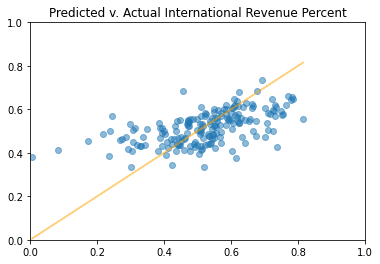

In [124]:
fig, ax = plt.subplots()
ax.plot(y_test,y_test,color='orange', alpha = .5)
ax.scatter(y_test,test_pred, alpha = .5)

plt.title('Predicted v. Actual International Revenue Percent')
ax.axes.set_xlim(0,1)
ax.axes.set_ylim(0,1)


In [120]:
list(zip(X_train.columns, lasso_model.coef_))

[('const', 0.0),
 ('year', 0.03162324803447938),
 ('run_time', 0.005712469350927722),
 ('budget_adj', 0.03441516992493835),
 ('Adam Sandler', -0.0),
 ('Angelina Jolie', 0.0),
 ('Anne Hathaway', 0.0),
 ('Antonio Banderas', -0.0),
 ('Ben Affleck', -0.0),
 ('Ben Stiller', 0.0),
 ('Brad Pitt', 0.0031910849268554815),
 ('Bruce Willis', 0.0),
 ('Cameron Diaz', 0.0),
 ('Cate Blanchett', 0.0),
 ('Chris Evans', -0.0),
 ('Chris Pratt', -0.0),
 ('Denzel Washington', -0.0),
 ('Dwayne Johnson', 0.0),
 ('Eddie Murphy', -0.0),
 ('Emma Watson', 4.558805936891728e-05),
 ('Harrison Ford', -0.0),
 ('Hugh Jackman', 0.0),
 ('Ian McKellen', 0.0),
 ('Jim Carrey', 0.0),
 ('John Travolta', -0.0),
 ('Johnny Depp', 0.0),
 ('Julia Roberts', 0.0),
 ('Kevin Hart', -0.004052518768435721),
 ('Leonardo DiCaprio', 0.0),
 ('Liam Neeson', 0.0),
 ('Mark Wahlberg', -0.0),
 ('Matt Damon', 0.0),
 ('Mel Gibson', 0.0),
 ('Morgan Freeman', 0.0),
 ('Owen Wilson', 0.0),
 ('Robert Downey Jr.', -0.0),
 ('Robin Williams', 0.0),
 ('R